### **Step 1**

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
# import shap
# from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

### **Step 2 Prepare Datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Final data**
* testing

In [ ]:
data=pd.read_csv("/content/Final_merged_obd_data2.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26982 entries, 0 to 26981
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Engine_RPM                   26982 non-null  float64
 1   Coolant_Temp_C               26982 non-null  float64
 2   Oil_Temp_C                   26982 non-null  float64
 3   Idle_Status                  26982 non-null  int64  
 4   Engine_Load_Percent          26982 non-null  float64
 5   Ignition_Timing_Deg          26982 non-null  float64
 6   MAP_kPa                      26982 non-null  float64
 7   MAF_gps                      26982 non-null  float64
 8   Battery_Voltage_V            26982 non-null  float64
 9   Charging_System_Status       26982 non-null  object 
 10  O2_Sensor_V                  26982 non-null  float64
 11  Catalytic_Converter_Percent  26982 non-null  float64
 12  EGR_Status                   26982 non-null  object 
 13  Vehicle_Speed_km

In [ ]:
value = "Fault_Type"

In [ ]:
less_than = data[data[value] < 0].shape[0]

greater_than_or_equal = data[data[value] >= 0].shape[0]

print(f"Number of values ​​in column ... that are less than: {less_than}")
print(f"Number of values ​​in column .... that are greater than or equal to: {greater_than_or_equal}")

In [ ]:
min = data[value].min()
max = data[value].max()

print(f"Miniman value {min}, and Maximum value {max}")

Miniman value 0.0, and Maximum value 4.0


In [ ]:
data[value].value_counts()

,count
Fault_Type,
0.0,3150
3.0,2771
2.0,2689
1.0,1841
4.0,1780


### **Processing missing values**

Fill values ​​with " mean and mod "

In [ ]:
data.isnull().sum()

,0
Engine_RPM,0
Coolant_Temp_C,0
Oil_Temp_C,0
Idle_Status,0
Engine_Load_Percent,0
Ignition_Timing_Deg,0
MAP_kPa,0
MAF_gps,0
Battery_Voltage_V,0
Charging_System_Status,0


In [ ]:
def fill_missing(data):
    """
    - Numeric columns: mean or median.
    - Categorical columns: most frequently occurring value.
    - Add new columns to indicate missing values.
    """

    for col in data.columns:

        if data[col].isnull().sum() == 0:
            continue

        data[f'is_missing_{col}'] = data[col].isnull().astype(int)

        if data[col].dtype in ['float64', 'int64','bool']:

            # median and mean

            if data[col].skew() > 1:
                data[col] = data[col].fillna(data[col].median())
            else:
                data[col] = data[col].fillna(data[col].mean())

        else:

            # Categorical columns: Substitute the most frequent value
            data[col] = data[col].fillna(data[col].mode()[0])

    return data

data = fill_missing(data)

In [ ]:
data = fill_missing(data)

### **Encoder**

In [ ]:
def encode_categorical_columns(data):
    label_encoders = {}

    encoded_data = data.copy()

    # define categorical columns
    categorical_cols = encoded_data.select_dtypes(include=['object']).columns

    binary_cols = []
    multi_cols = []

    # binary and multivalued columns
    for col in categorical_cols:
        unique_vals = encoded_data[col].nunique()
        if unique_vals == 2:
            binary_cols.append(col)
        elif unique_vals > 2:
            multi_cols.append(col)

    # LabelEncoder
    for col in binary_cols:
        le = LabelEncoder()
        encoded_data[col] = le.fit_transform(encoded_data[col])
        label_encoders[col] = le

    # OneHotEncoder
    if multi_cols:
        onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
        onehot_encoded = onehot_encoder.fit_transform(encoded_data[multi_cols])
        onehot_cols = onehot_encoder.get_feature_names_out(multi_cols)

        #DataFrame
        onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_cols, index=encoded_data.index)

        # Removing original columns
        encoded_data = encoded_data.drop(columns=multi_cols)

        # Merge original data with onehot_data
        encoded_data = pd.concat([encoded_data, onehot_df], axis=1)

        # Save info of OneHotEncoder
        label_encoders['onehot_encoder'] = onehot_encoder
        label_encoders['onehot_columns'] = multi_cols

    return encoded_data, label_encoders

In [ ]:
data, encoders = encode_categorical_columns(data)
joblib.dump(encoders, 'encoders.pkl')

In [ ]:
joblib.dump(encoders, 'encoders.pkl')
## Download encoders from file
# loaded_encoders = joblib.load('encoders.pkl')

In [ ]:
data.info()

### **Neural Network using PyTorch**

* Not need this Model X

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Load the data (assuming 'data' is your processed DataFrame)
# ... (Your existing data loading and preprocessing code) ...


# Separate features (X) and target (y)
X = data.drop('Fault_Type', axis=1)
y = data['Fault_Type']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long) # Assuming 'y' is categorical
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Define the neural network architecture
class Net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):

        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


# Hyperparameters
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = len(y_train.unique()) # Number of unique classes in the target
learning_rate = 0.001
num_epochs = 100

# Create model, loss function, and optimizer
model = Net(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

#-------------------------------------------------------------------------------
# Evaluation
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted == y_test).sum().item()
    print(f'Accuracy of the network on the test set: {100 * correct / total}%')

### **XGBoost**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26982 entries, 0 to 26981
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Engine_RPM                     26982 non-null  float64
 1   Coolant_Temp_C                 26982 non-null  float64
 2   Oil_Temp_C                     26982 non-null  float64
 3   Idle_Status                    26982 non-null  int64  
 4   Engine_Load_Percent            26982 non-null  float64
 5   Ignition_Timing_Deg            26982 non-null  float64
 6   MAP_kPa                        26982 non-null  float64
 7   MAF_gps                        26982 non-null  float64
 8   Battery_Voltage_V              26982 non-null  float64
 9   O2_Sensor_V                    26982 non-null  float64
 10  Catalytic_Converter_Percent    26982 non-null  float64
 11  Vehicle_Speed_kmh              26982 non-null  float64
 12  Tire_Pressure_psi              26982 non-null 

In [ ]:
data['Fault_Type'].value_counts()

,count
Fault_Type,
2,6190
3,5933
0,5803
4,4529
1,4527


In [ ]:
!pip install kaleido -quiet


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


**Train test split**

In [ ]:
X, y = data.drop('Fault_Type', axis=1), data[['Fault_Type']]

In [ ]:
print("shapes (X):", X.shape)
print("shapes (y):", y.shape)

shapes (X): (26982, 47)
shapes (y): (26982, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

In [ ]:
print("number of train data :", X_train.shape)
print("number of train data :", X_test.shape)

number of train data : (20236, 47)
number of train data : (6746, 47)


In [ ]:
# XGBoost configuration
xgb_model = xgb.XGBClassifier(objective='multi:softmax',
                              eval_metric='mlogloss',
                              random_state=42,
                              early_stopping_rounds=10)

In [ ]:
# Training
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1379
           1       1.00      0.99      1.00      1146
           2       0.99      0.99      0.99      1607
           3       0.99      0.99      0.99      1497
           4       0.99      1.00      1.00      1117

    accuracy                           0.99      6746
   macro avg       0.99      0.99      0.99      6746
weighted avg       0.99      0.99      0.99      6746



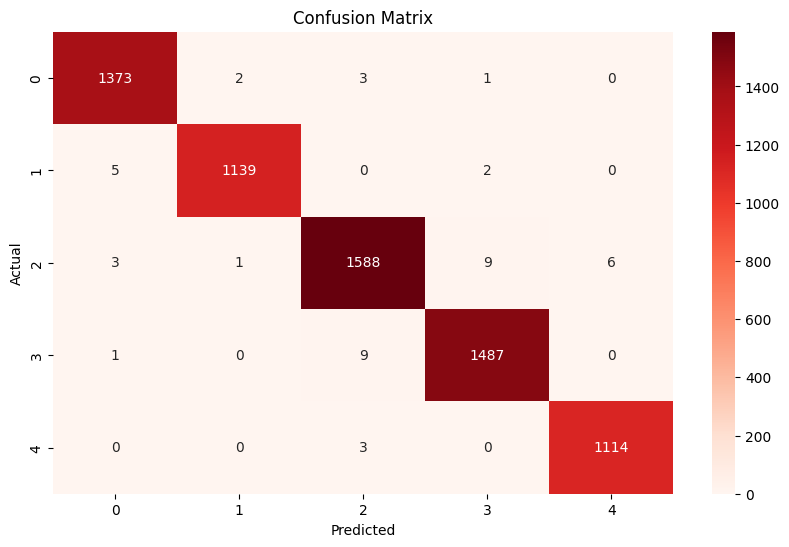

In [ ]:
y_pred = xgb_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

Balanced Accuracy: 0.9936703506486708


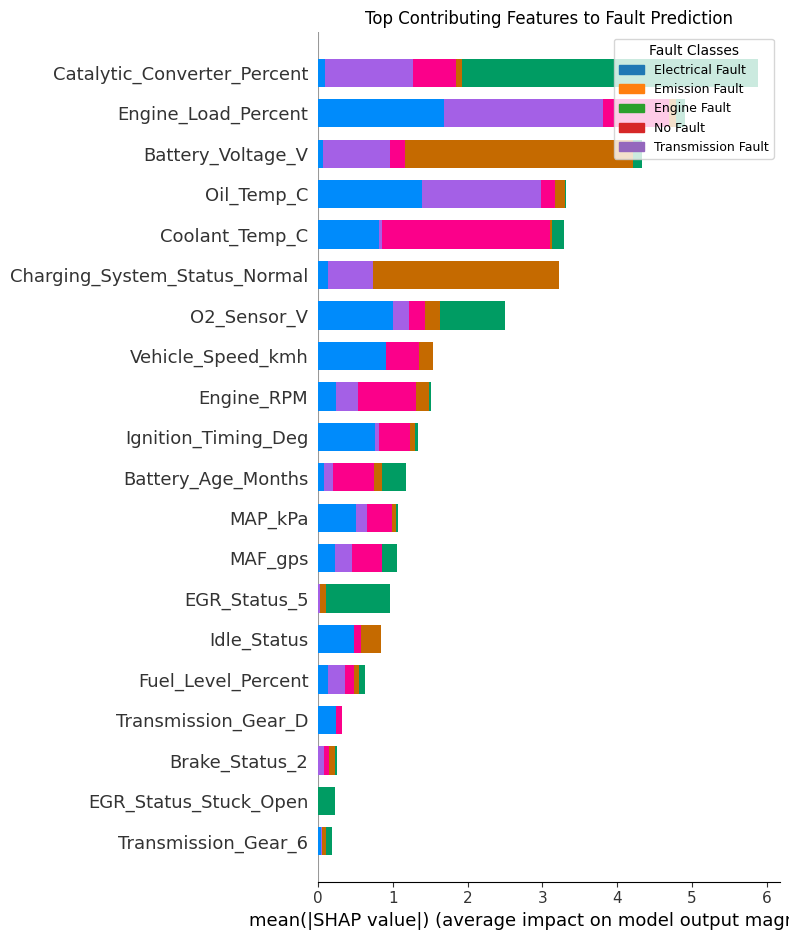

In [ ]:
import shap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

plt.title("Top Contributing Features to Fault Prediction", fontsize=12)

legend_labels = [
    ("Electrical Fault", "C0"),    # class 0
    ("Emission Fault", "C1"),      # class 1
    ("Engine Fault", "C2"),        # class 2
    ("No Fault", "C3"),            # class 3
    ("Transmission Fault", "C4")   # class 4
]

legend_patches = [Patch(color=color, label=label) for label, color in legend_labels]
plt.legend(handles=legend_patches, title="Fault Classes", loc="upper right", fontsize=9, title_fontsize=10)

# Improve shape
plt.tight_layout()

plt.savefig("shap_fault_feature_importance.png", bbox_inches="tight")
plt.show()

### **Optimizers the Model**

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# GridSearchCV training
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='multi:softmax',
                                                       eval_metric='mlogloss',
                                                       random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_weighted',
                           n_jobs=-1,
                           verbose=1)

# GridSearchCV training
grid_search.fit(X_train, y_train)

# The best model
print("Best parameters:", grid_search.best_params_)
print("Best F1:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

In [ ]:
print("classification report:")
print(classification_report(y_test, y_pred_best))

### **Evaluations**

In [ ]:
# ROC-AUC evaluation (for binary or multiclass classification with one-vs-rest)

if len(np.unique(y)) == 2:
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
else:
    print("ROC-AUC for multi-class classification requires one-vs-rest calculation (skip here).")

### **Save and Load**

In [ ]:
xgb_model.save_model('car_fault_classifier.json')
print("saved Model is Done::'car_fault_classifier.json'")

In [ ]:
import xgboost as xgb
import joblib

model1 = xgb.XGBClassifier()
model1.load_model('/content/car_fault_classifier.json')

In [ ]:
new_data = pd.read_csv('/content/test_datasets.csv')

In [ ]:
# Handling missing values
for column in new_data.columns:
    if new_data[column].dtype in ['int64', 'float64','bool']:
        new_data[column].fillna(new_data[column].mean(), inplace=True)
    else:
        new_data[column].fillna(new_data[column].mode()[0], inplace=True)

In [ ]:
# encoding categorical columns using LabelEncoders saved

for column in new_data.select_dtypes(include=['object']).columns:
    if column in encoders:
        new_data[column] = encoders[column].transform(new_data[column])
    else:
        print(f"Warning: Column {column} was not present in the training data")

# ensure columns match the training data.
expected_columns = X.columns
new_data = new_data[expected_columns]

تحذير: العمود Timestamp لم يكن موجودًا في بيانات التدريب
تحذير: العمود Date لم يكن موجودًا في بيانات التدريب


KeyError: "['Battery_Age_Months', 'Charging_System_Status_1', 'Charging_System_Status_2', 'Charging_System_Status_3', 'Charging_System_Status_4', 'Charging_System_Status_Fault', 'Charging_System_Status_Normal', 'EGR_Status_1', 'EGR_Status_2', 'EGR_Status_3', 'EGR_Status_4', 'EGR_Status_5', 'EGR_Status_Closed', 'EGR_Status_Open', 'EGR_Status_Stuck_Open', 'Transmission_Gear_1', 'Transmission_Gear_2', 'Transmission_Gear_3', 'Transmission_Gear_4', 'Transmission_Gear_5', 'Transmission_Gear_6', 'Transmission_Gear_7', 'Transmission_Gear_8', 'Transmission_Gear_9', 'Transmission_Gear_D', 'Transmission_Gear_N', 'Transmission_Gear_P', 'Transmission_Gear_R', 'Brake_Status_1', 'Brake_Status_2', 'Brake_Status_Engaged', 'Brake_Status_Released'] not in index"

In [ ]:
new_data.columns

Index(['Timestamp', 'Engine_RPM', 'Coolant_Temp_C', 'Oil_Temp_C',
       'Idle_Status', 'Engine_Load_Percent', 'Ignition_Timing_Deg', 'MAP_kPa',
       'MAF_gps', 'Battery_Voltage_V', 'Charging_System_Status', 'O2_Sensor_V',
       'Catalytic_Converter_Percent', 'EGR_Status', 'Vehicle_Speed_kmh',
       'Transmission_Gear', 'Brake_Status', 'Tire_Pressure_psi',
       'Ambient_Temp_C', 'Fuel_Level_Percent', 'Fault_Type', 'Date'],
      dtype='object')

In [ ]:
data.columns

Index(['Engine_RPM', 'Coolant_Temp_C', 'Oil_Temp_C', 'Idle_Status',
       'Engine_Load_Percent', 'Ignition_Timing_Deg', 'MAP_kPa', 'MAF_gps',
       'Battery_Voltage_V', 'O2_Sensor_V', 'Catalytic_Converter_Percent',
       'Vehicle_Speed_kmh', 'Tire_Pressure_psi', 'Ambient_Temp_C',
       'Fuel_Level_Percent', 'Fault_Type', 'Battery_Age_Months',
       'Charging_System_Status_1', 'Charging_System_Status_2',
       'Charging_System_Status_3', 'Charging_System_Status_4',
       'Charging_System_Status_Fault', 'Charging_System_Status_Normal',
       'EGR_Status_1', 'EGR_Status_2', 'EGR_Status_3', 'EGR_Status_4',
       'EGR_Status_5', 'EGR_Status_Closed', 'EGR_Status_Open',
       'EGR_Status_Stuck_Open', 'Transmission_Gear_1', 'Transmission_Gear_2',
       'Transmission_Gear_3', 'Transmission_Gear_4', 'Transmission_Gear_5',
       'Transmission_Gear_6', 'Transmission_Gear_7', 'Transmission_Gear_8',
       'Transmission_Gear_9', 'Transmission_Gear_D', 'Transmission_Gear_N',
       'Trans